## Naive Bayes Classifier using 2016 Presidental Debate Corpus


***Author: Aaron McMoran***

5/8/2016

<img src="images/bernie_and_hilary.jpg" style="width: 500px;"/>

***Motivation:*** The 2016 presidential race is underway and many americans don't have the time and energy to research each candidate.  Thankfully, our favorite media outlets sponser debates so that the candidates can duke it out on live television for the american people to decide who they agree with the most. 

***Goal: *** Train a candidate classifier using their 2016 presidential debate rhetoric to predict which comment came from which candidate.

***Dataset Source:*** The data was retrieved from The American Presidency project.  They have all presidential debate transcripts since the 1960 election.  The data is located here: http://www.presidency.ucsb.edu/debates.php

---
Retrieving the Data
----

In [ ]:
reset -fs

In [1]:
import requests
from bs4 import BeautifulSoup
import sys
import re
from collections import defaultdict, Counter
import nltk
import sklearn
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn import feature_extraction
from sklearn import cross_validation
from sklearn import linear_model
from sklearn import grid_search
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
sys.setrecursionlimit(2000)

In [2]:
class DebateData(object):
    '''An election debate Data extration class'''

    def __init__(self, year=2016):
        ''' year:  year of election
            election_range: how far back to grab urls for election year
            text_source: data source containing links for debate transcripts
            urls: all debate urls for this election year
            year_link_lst: list of tuples that contain year and link (year, link) for all debates
            speakers: list of speakers for this years election (includes any and all speakers)'''
        self.year = year
        self.election_range = 0
        self.text_source = "http://www.presidency.ucsb.edu/debates.php"
        self.urls_ = []
        self.year_link_list = []
        self.speakers = []
        
    def get_election_links(self):
        """Based off election the year, extract the debate text from the debates
        that occured for that election"""
        soup = self.get_soup(self.text_source)
        #Build out zipped list of year and debate links
        years, links, modifiedlist=[],[],[]
        for idx, row in enumerate(soup.find_all('td')):
            for i in row.find_all('td'):
                for j in i.find_all('td'):
                    for k in j.find_all('td'):
                        for l in k.find_all('tr'):
                            if l.find_all(class_="docdate") and l.find_all(class_="doctext") and l.find_all('a'):
                                for link in l.find_all('a'):
                                    links.append(link.get('href'))
                                temp = str(l.find_all(class_='docdate'))
                                yr = temp.split(", ")[1][:4]
                                years.append(int(yr))
        self.year_link_list = sorted(zip(years,links), reverse = True)
        #if we want to return all debates/candidates or if we want just the debates/candidates for an election year
        if self.year == 'all':
            return self.year_link_list
        else:
            self.election_range = self.year-4
            for debyear, deblink in self.year_link_list:
                if debyear > self.election_range and debyear <= self.year:
                    self.urls_.append(deblink)
                    modifiedlist.append((debyear,deblink))
                self.year_link_list = modifiedlist
    
    def get_soup(self, link): 
        "Build the soup"
        return BeautifulSoup(requests.get(link).content, 'html.parser')
                    
    def get_speakers(self):
        """Identify the speakers (candidates, moderators, panelists) by using bold html tags. 
        Remove bold tags that are not speakers"""
        self.speakers=[]
        for debate in self.urls_:
            debspeakers=[]
            soup = self.get_soup(debate)
            texttest = soup.find(class_='displaytext')
            speakers = texttest.find_all('b')
            for speaker in speakers:
                spkrtrm = speaker.get_text()
                #get rid of bold tokens that are not speakers
                if spkrtrm not in ("PARTICIPANTS:","MODERATOR:","PANELIST:"
                                   ,"MODERATORS:","PANELISTS:"," ",'.','...','???:','] ' ):
                    debspeakers.append(spkrtrm)
            self.speakers.extend(debspeakers)
        self.speakers = set(self.speakers)
    
    def get_text(self):
        "get the text for each candidate (TRUMP,CRUZ,KASICH,CLINTON,SANDERS)"
        all_text = []
        for link in self.urls_:
            soup = self.get_soup(link)
            text = soup.find(class_='displaytext').get_text()
            all_text.append(text)
        all_text = ",".join(all_text)
        all_text.replace("\'","'")
        #SOURCE - http://www.dotnetperls.com/find-python
        lst = []
        for speaker in self.speakers:
        # Start with this value.
            location = -1
            while True:
            # Advance location by 1.
                location = all_text.find(speaker, location +1)
                if location != -1:
                    lst.append((location,speaker))
                if location == -1: break
        locspkr = sorted(lst)
        textdict = defaultdict(list)
        cand = ["TRUMP:","CLINTON:","SANDERS:"]
        for idx,(i,j) in enumerate(locspkr):
            if j in cand:
                start = i + len(j)
                if idx+1 == len(locspkr):
                    textdict[j].append(all_text[start:locspkr[idx][0]])
                else:
                    textdict[j].append(all_text[start:locspkr[idx+1][0]])
        return textdict

## Create Debate Instance


In [3]:
#Create debate data instance for 2016 election year
dd = DebateData(2016)
#Get the links that have the transcripts
dd.get_election_links()
#get all of the speakers from the debates
dd.get_speakers()
#Returns a dictionary with candidates as keys and a list of strings as their comments
dtext = dd.get_text()

## Quick look at the data

In [4]:
#Comments per Candidate
comments = [(key.title()[:-1],len(dtext[key])) for key in dtext.keys()]
comments

[('Sanders', 625), ('Clinton', 564), ('Trump', 760)]

In [5]:
#looking at the data in raw form
dtext["TRUMP:"][:2]

[" One of the biggest political events anywhere in the world is happening right now with the Republican Party. Millions and millions of people are going out to the polls and they're voting. They're voting out of enthusiasm. They're voting out of love. Some of these people, frankly, have never voted before — 50 years old, 60 years old, 70 years old — never voted before.We're taking people from the Democrat Party. We're taking people as independents, and they're all coming out and the whole world is talking about it. It's very exciting. I think, frankly, the Republican establishment, or whatever you want to call it, should embrace what's happening.We're having millions of extra people join. We are going to beat the Democrats. We are going to beat Hillary or whoever it may be. And we're going to beat them soundly. [applause]",
 " Because nobody knows the system better than me. I know the H1B. I know the H2B. Nobody knows it better than me. I'm a businessman. These are laws. These are regu

## EDA and Build Input for Classifiers

In [6]:
#Remove Punctuation and build X and y for classifiers
y,X=[],[]
from string import punctuation
for key in dtext.keys():
    for idx, comment in enumerate(dtext[key]):
        dtext[key][idx] = dtext[key][idx].replace('\'', '').replace('!', '').replace('.', ' ').replace(',', '').replace(':', '').replace('?', '').replace('\"', '').replace(')','').replace('(','').replace(';','')
        y.append(key)
        X.append(dtext[key][idx])

In [7]:
dtext["TRUMP:"][0].strip()

'One of the biggest political events anywhere in the world is happening right now with the Republican Party  Millions and millions of people are going out to the polls and theyre voting  Theyre voting out of enthusiasm  Theyre voting out of love  Some of these people frankly have never voted before — 50 years old 60 years old 70 years old — never voted before Were taking people from the Democrat Party  Were taking people as independents and theyre all coming out and the whole world is talking about it  Its very exciting  I think frankly the Republican establishment or whatever you want to call it should embrace whats happening Were having millions of extra people join  We are going to beat the Democrats  We are going to beat Hillary or whoever it may be  And were going to beat them soundly  [applause]'

In [8]:
#Additional stopwords were added to the nltk corpus
from nltk.corpus import stopwords

In [9]:
#Create Bag of Word dictionary for candidates and remove stop words for EDA
edadict = {}
for key in dtext.keys():
    edadict[key] = nltk.word_tokenize(",".join(dtext[key]).lower())
    edadict[key] = [word for word in edadict[key] if word not in stopwords.words('english')]

## Candidates Favorite Words

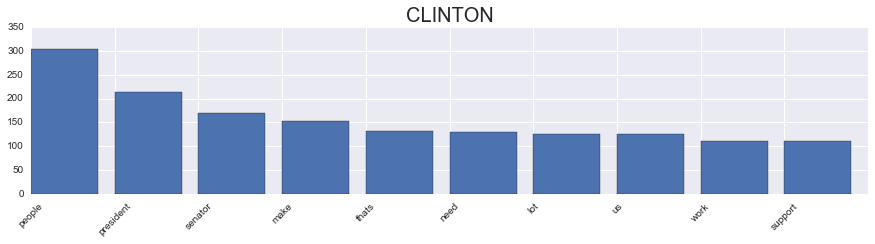

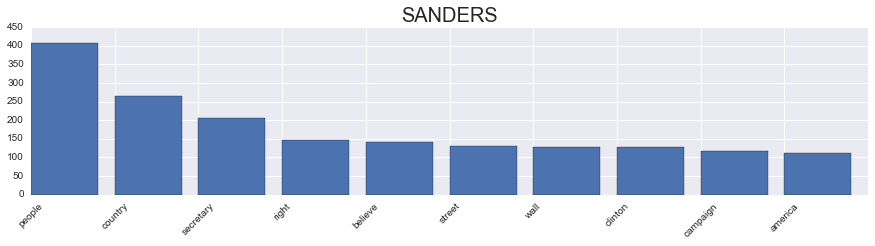

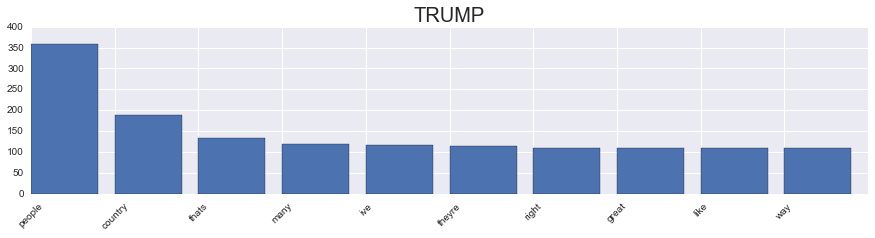

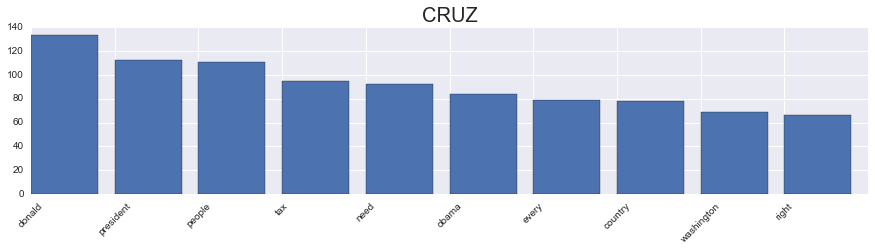

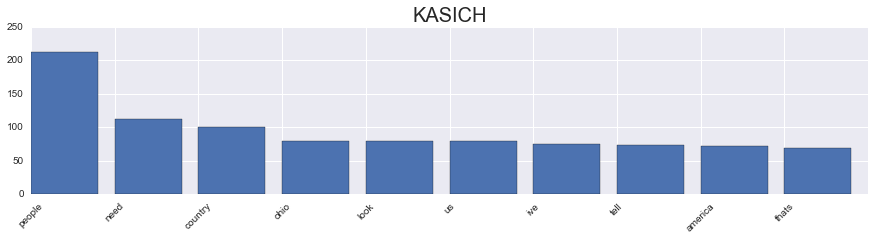

In [13]:
for key in edadict.keys():
    wordcount = Counter(edadict[key]).most_common(10)
    words = [word for word, count in wordcount]
    counts = [count for word, count in wordcount]
    plt.figure(figsize = (15,3))
    plt.bar(range(len(wordcount)),counts)
    plt.yticks(fontsize=10)
    plt.tick_params(labelsize=10)
    plt.xticks(range(len(wordcount)),words, rotation=45)
    plt.title(key[:-1], fontsize=20)

***Since the candidates most popular words are all very similar, it may not end up being a good classification feature ***

## Candidate Vocabulary

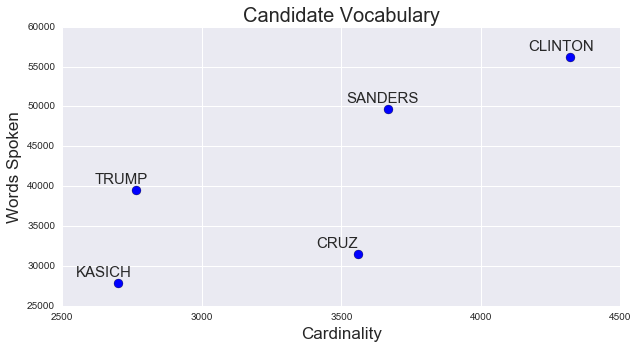

In [14]:
#Keeping Stop words but removing puncutation misses
stop = ["-","—","]","[",",","','"]
cands, card, words = [],[],[]
edadict = {}
for key in dtext.keys():
    edadict[key] = nltk.word_tokenize(",".join(dtext[key]).lower())
    edadict[key] = [word for word in edadict[key] if word not in stop]
cardinality = [(key,len(set(edadict[key])),len(edadict[key])) for key in edadict.keys()]

#plotting Cardinality
for i,j,k in cardinality:
    cands.append(i)
    card.append(j)
    words.append(k)
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(card, words, s=80)
for i, txt in enumerate(cands):
    ax.annotate(txt[:-1],(card[i]-150,words[i]+2200),verticalalignment='top',fontsize=15,)
plt.xlabel("Cardinality",fontsize=17)
plt.ylabel("Words Spoken", fontsize = 17)
plt.title("Candidate Vocabulary", fontsize=20)
plt.show()  

***We can see here that Kasich has the smallest vocabulary of the candidates; however, he also spoke the fewest words of the candidates so that would be expected.  What is interesting is that while Trump spoke over 10,000 more words than Kasich his vocabulary barely increased.  On the other hand, Cruz only spoke a few thousand words more than Kasich, but his vocabulary is substantially more broad than Trump's and Kasich's.*** 

## Who received the most applause?

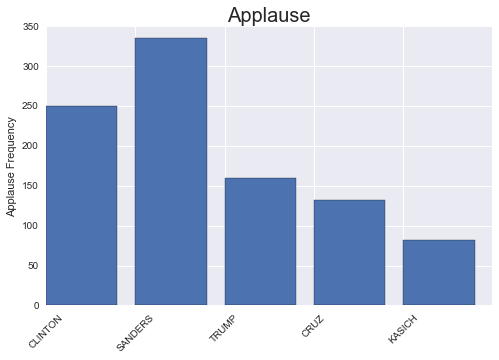

In [20]:
applause=[]
for key in edadict.keys():
    count = Counter(edadict[key])
    applause.append((key,count["applause"]))
cands = [cand[:-1] for cand, count in applause]
counts = [count for cand, count in applause]
plt.figure(figsize = (8,5))
plt.bar(range(len(applause)),counts)
plt.yticks(fontsize=10)
plt.ylabel("Applause Frequency")
plt.tick_params(labelsize=10)
plt.xticks(range(len(applause)),cands, rotation=45, fontsize = 10)
plt.title("Applause", fontsize=20)
plt.show()

***Could applause be used as a predictor for the republican and democratic nominee?***

---
Naive Bayes is often a good starting point for text analysis
----



### Naive Bayes is Applicable Where:

1. n << p (# of features) (you have fewer samples than features)
2. n somewhat small __or__ 
3. n quite large
4. streams of input data (online learning)
5. not bounded by memory (data usually stored as in-place tables)
6. Multi-class

### Why Text?

Text data happens to fit very nicely to the bullet points of __Where/When__ to use Naive Bayes.  Due to bag of words featurization of text, the input feature matrix is often very wide (~10,000 - 50,000 columns/dimensions) and can even be greater than the number of data samples (n << p).

Source - Jared Thompson lecture, 4.2, 04/17/2106

In [10]:
#First go with a Multinomial Naive Bayes Classifier
vectount = sklearn.feature_extraction.text.CountVectorizer()
vectfit = vectount.fit_transform(X)
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(
    vectfit, y, test_size=0.1, random_state =1)
NBtest = MultinomialNB()
NBtest.fit(X_train,y_train)
predictions = NBtest.predict(X_test)
score = NBtest.score(X_test,y_test)*100
print("Accuracy: %0.2f"% score,"%")

Accuracy: 81.03 %


***That's a pretty good accuracy for our first shot, but let's check with some other classifiers to make sure our intuition serves us right***

---
Comparing Random Forest, Multinomial Bayes, Logistic Regression, kNN, and Ensemble
----

In [430]:
clf1 = RandomForestClassifier(random_state=1, n_jobs=-1)
clf2 = MultinomialNB()
clf3 = sklearn.linear_model.LogisticRegression(solver='lbfgs',multi_class='multinomial',random_state=1)
clf4 = KNeighborsClassifier(n_neighbors=5)
eclf = VotingClassifier(estimators=[('rf', clf1), ('mnb', clf2),('lg', clf3),('knn',clf4)], voting='hard')

for clf, label in zip([clf1, clf2,clf3, clf4, eclf], ['Random Forest', 'Multinomial Bayes','Logistic Regression',
                                                      'kNN', 'Ensemble']):
    scores = cross_validation.cross_val_score(clf, vecfit, y, cv=5, scoring='accuracy', n_jobs=-1)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),"%", scores.std(), label))

Accuracy: 0.49 (+/- 0.02) [Random Forest]
Accuracy: 0.71 (+/- 0.01) [Multinomial Bayes]
Accuracy: 0.62 (+/- 0.02) [Logistic Regression]
Accuracy: 0.40 (+/- 0.03) [kNN]
Accuracy: 0.62 (+/- 0.02) [Ensemble]


***Looking at the default models for Random Forest, Multinomial Bayes, Logistic Regression and kNN it appears that Multinomial Bayes outperforms the other classifiers when using sci-kit learns default parameters for the estimators.  I decided to go ahead with using Multinomial Bayes as my estimator. Now, I am going to try to optimize the hyper parameters for this classifier.***

---
Grid Search Multinomial Bayes
----

In [50]:
import time
start = time.time()

#Import Custom stop words
stop = stopwords.words('english')

#build vectorizor and split the data
vecount = sklearn.feature_extraction.text.CountVectorizer()
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(
    X, y, test_size=0.1, random_state = 1)

paramsvec = [{'vect__ngram_range':[(1,3)],'vect__stop_words':[stop,None],
              'mnb__alpha':[.4,.5,.6,.7,.8,.9,1.0,1.5],'mnb__fit_prior':[True,False]}]

#Using Countvectorizer
NB_vect = Pipeline([('vect',vecount),('mnb',MultinomialNB())])
gs_NB_vect = grid_search.GridSearchCV(NB_vect,paramsvec,scoring='accuracy', cv=5, n_jobs=-1)
gs_NB_vect.fit(X_train,y_train)

#How long did it take?
end = time.time()
elapsed = end - start
print("Time taken for GridSearch: ", elapsed, "seconds.")

Time taken for GridSearch:  77.53289604187012 seconds.


In [52]:
print("Best Score: %0.2f  " % gs_NB_vect.best_score_)
print("Best Parameters: ", gs_NB_vect.best_params_)

Best Score: 0.77  
Best Parameters:  {'mnb__alpha': 0.4, 'vect__ngram_range': (1, 3), 'vect__stop_words': None, 'mnb__fit_prior': True}


*** The results indicate that the smoothing parameter (alpha) for words that do not show up in the corpus should be less than half of what the normal smoothing coefficient is set to (1.0).  In addition, it appears that stop words are very important when classifying the candidates.  Also, the maximum number of ngrams (bigrams and trigrams) were used for optimizing classification, indicating context is important for classification***

---
Building Optimal Classifier
----

In [11]:
#Classifying
vecount = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(1,3))
vecfit = vecount.fit_transform(X)
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(
    vecfit, y, test_size=0.1, random_state =1)
NB1 = MultinomialNB(alpha=0.4, fit_prior=True)
NB1.fit(X_train,y_train)
predictions = NB1.predict(X_test)
score = NB1.score(X_test,y_test)*100
print("Accuracy: %0.2f"% score,"%")

Accuracy: 83.59 %


In [12]:
scores = cross_validation.cross_val_score(NB1,vecfit, y, cv=5, scoring="accuracy",n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy: 0.80 (+/- 0.03)


---
Comparing TFIDF Feature Matrix
----

In [468]:
vecounttfidf = sklearn.feature_extraction.text.TfidfVectorizer(ngram_range=(1,3))
vecfittfidf = vecounttfidf.fit_transform(X)
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(
    vecfittfidf, y, test_size=0.1, random_state = 1)
NBtfidf = MultinomialNB(fit_prior=True, alpha = 0.4)
NBtfidf.fit(X_train,y_train)
NBtfidf.score(X_test,y_test)

0.67843137254901964

In [470]:
scores = cross_validation.cross_val_score(NBtfidf,vecfittfidf, y, cv=5, scoring="accuracy",n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy: 0.64 (+/- 0.03)


*** Realizing I did not optimize the hyperparameters for the TFIDF Vectorizer, I did want to see what the optimized parameters for Multinomial Bayes classifier looked like with a TFIDF feature matrix. Using the optimized Multinomial Bayes parameters with the tfidf vectorizer I recieved a lower accuracy score***

---
Test Multinomial Bayes Classifier with some examples from the Web
----

<img src="images/candidates.jpg" style="width: 500px;"/>


***Trump:*** *"I will build a great wall and nobody builds walls better than me believe me and I'll build them very inexpensively. I will build a great great wall on our southern border and I will make mexico pay for that wall mark my words."*   [Source](https://www.facebook.com/VoteForDonaldTrump/posts/835365566532258)

***Clinton:*** *"People can judge me for what I've done. And I think when somebody's out in the public eye, that's what they do. So I'm fully comfortable with who I am, what I stand for, and what I've always stood for."*[Source](http://www.brainyquote.com/quotes/quotes/h/hillarycli676698.html)

***Sanders:*** *"A nation will not survive morally or economically when so few have so much and so many have so little."*   [Source](http://www.azquotes.com/quote/1206371)

***Cruz:*** *"We need to remain a nation that doesn't just welcome but that celebrates legal immigrants who come here seeking to pursue the American Dream."*[Source](http://www.brainyquote.com/quotes/quotes/t/tedcruz519507.html)


***Kasich:*** *"We just got an army of people, who, and many women, who left their kitchens to go out and to go door-to-door and to put up yard signs for me."*   [Source](https://twitter.com/kailanikm/status/701820038869819393?ref_src=twsrc%5Etfw)

***Trump:*** *"Happy Cinco de Mayo! The best taco bowls are made in Trump Tower Grill. I love Hispanics!"*    [Source](https://twitter.com/realdonaldtrump/status/728297587418247168)

In [19]:
classify = ['i will build a great wall and nobody builds walls better than me believe me and ill build them very inexpensively i will build a great great wall on our southern border and I will make mexico pay for that wall mark my words',"People can judge me for what I've done. And I think when somebody's out in the public eye, that's what they do. So I'm fully comfortable with who I am, what I stand for, and what I've always stood for.","A nation will not survive morally or economically when so few have so much and so many have so little.", "Happy Cinco de Mayo! The best taco bowls are made in Trump Tower Grill. I love Hispanics!'","I am donald trump"]

In [20]:
comments = vecount.transform(classify)

In [21]:
NB1.predict(comments)

array(['TRUMP:', 'CLINTON:', 'SANDERS:', 'TRUMP:', 'SANDERS:'], 
      dtype='<U8')

*** Five out of six! Not bad!***

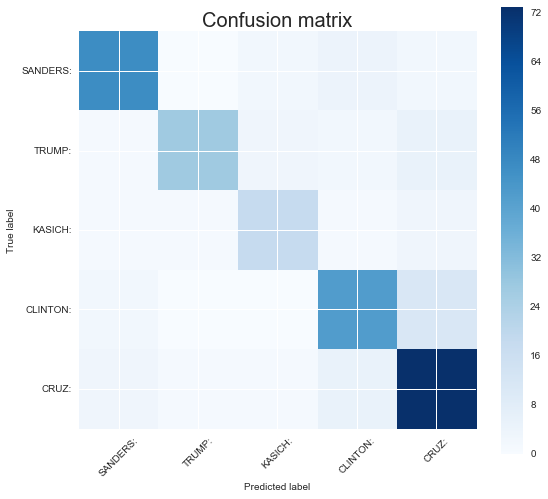

In [489]:
#source - http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(set(y_test)))
    plt.xticks(tick_marks, set(y_test), rotation=45)
    plt.yticks(tick_marks, set(y_test))
    plt.tight_layout()
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label',fontsize=10)

# Compute confusion matrix and plot
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,7))
plot_confusion_matrix(cm)

***Interesting that the model often confuses Clinton and Cruz, even though they belong to different presidential parties.  I suspect Kasich is tough to identify due to the fact that there is not as much data for him.  Also, there seems to be a trend with true positives and cardinality/number of words spoken.  Candidates that had a wider vocabulary were easier to classify than those with a smaller vocabulary.  ***

## Storing Model

In [502]:
import pickle
import os
dest = os.path.join('2016_candidate_classifier','pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)
#pickling classifier
pickle.dump(NB1, open(os.path.join(dest,'classifier.pkl'),'wb'),protocol=4)
#pickling Vectorizer
pickle.dump(vecount, open(os.path.join(dest,'Countvec.pkl'),'wb'),protocol=4)

## Try for yourself!

***Following Sebastian Raschka's instructions in chapter 9 of "Python Machine Learning" I used Flask to build a very simple webpage for using the classifier on the web.***

http://almcmoran12.pythonanywhere.com/

## Next Steps

* Generalize DebateData class for prior presidential election debates
* Train and analyze a NeuralNet classifier
* Implement Word2Vec on the corpus
* Add a feedback loop on the webpage so that the classifier can get retrained on new data
* Topic modeling per candidate or per debate